In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image


# Keras
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Flatten

# ライブラリのインポート
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.optimizers import RMSprop
from keras.utils import np_utils
import keras

# データの分割
from sklearn.model_selection import train_test_split


# JupyterNotebook上でグラフを表示する設定
%matplotlib inline
# DataFrameで全ての列を表示する設定
pd.options.display.max_columns = None

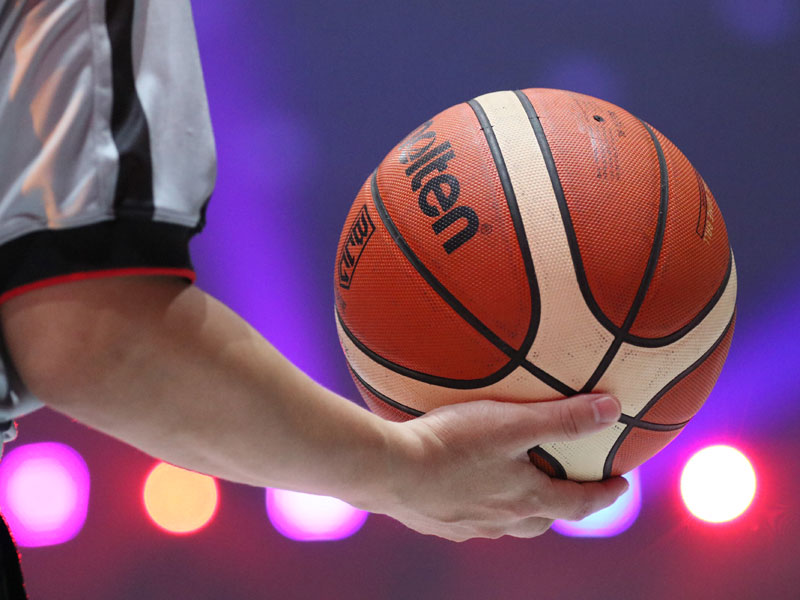

In [2]:
# バスケットボールの画像を表示
from IPython.display import Image,display_jpeg

display_jpeg(Image("./basketball/000001.jpg"))

In [4]:
from PIL import Image
import os, glob
import numpy as np
from PIL import ImageFile
# IOError: image file is truncated (0 bytes not processed)回避のため
ImageFile.LOAD_TRUNCATED_IMAGES = True

classes = ["basketball", "soccer"]
num_classes = len(classes)
image_size = 100
num_testdata = 25

X_train = []
X_test  = []
y_train = []
y_test  = []

for index, classlabel in enumerate(classes):
    photos_dir = "./" + classlabel
    files = glob.glob(photos_dir + "/*.jpg")
    for i, file in enumerate(files):
        image = Image.open(file)
        image = image.convert("RGB")
        image = image.resize((image_size, image_size))
        data = np.asarray(image)
        if i < num_testdata:
            X_test.append(data)
            y_test.append(index)
        else:
            
            for angle in range(-20, 20, 5):

                img_r = image.rotate(angle)
                data = np.asarray(img_r)
                X_train.append(data)
                y_train.append(index)
                # FLIP_LEFT_RIGHT　は 左右反転
                img_trains = img_r.transpose(Image.FLIP_LEFT_RIGHT)
                data = np.asarray(img_trains)
                X_train.append(data)
                y_train.append(index)

X = np.array(X_train)
X_test  = np.array(X_test)
Y = np.array(y_train)
Y_test  = np.array(y_test)

print(X.shape)
print(Y.shape)
print(X_test.shape)
print(Y_test.shape)

(1504, 100, 100, 3)
(1504,)
(50, 100, 100, 3)
(50,)


In [5]:
# カテゴリー変数への展開
from tensorflow.keras.utils import to_categorical

Y = to_categorical(Y)

In [6]:
# データの分割
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.3, random_state=0)

In [7]:
# 形状確認
print("X_train:", X_train.shape, "Y_train:", Y_train.shape)
print("X_test:", X_test.shape, "Y_test:", Y_test.shape)
print("X_valid:", X_valid.shape, "Y_valid:", Y_valid.shape)

X_train: (736, 100, 100, 3) Y_train: (736, 2)
X_test: (452, 100, 100, 3) Y_test: (452, 2)
X_valid: (316, 100, 100, 3) Y_valid: (316, 2)


In [8]:
# モデルの初期化
model = keras.Sequential()

# 入力層
model.add(Conv2D(
    32, kernel_size=3, padding="same",
    input_shape=(100, 100, 3,), activation="relu"
    ))
# プーリング層
model.add(MaxPooling2D(pool_size=(2, 2))) # (2, 2) は画像をそれぞれの次元で半分
# ドロップアウト層
model.add(Dropout(0.25))

# 層のユニットの繰り返し
model.add(Conv2D(26, kernel_size=3, padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Dropout(0.5))

# 1次元に変換
model.add(Flatten())
model.add(Dense(32, activation="relu", kernel_regularizer=regularizers.l2(0.001))) # 正則化
model.add(Dropout(0.5))

# 出力層
model.add(Dense(2, activation='softmax'))

# モデルの構築
model.compile(optimizer = "rmsprop", loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 26)        7514      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 26)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25, 25, 26)        0         
_________________________________________________________________
flatten (Flatten)            (None, 16250)             0

In [10]:
%%time

log = model.fit(X_train, Y_train, epochs=80, batch_size=32, verbose=True,
                callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss',
                                                        min_delta=0, patience=100, 
                                                         verbose=1)],
               validation_data=(X_valid, Y_valid))

Epoch 1/80
23/23 [==============================] - 5s 197ms/step - loss: 77.1516 - accuracy: 0.5122 - val_loss: 0.7260 - val_accuracy: 0.5222
Epoch 2/80
23/23 [==============================] - 4s 188ms/step - loss: 0.7603 - accuracy: 0.5041 - val_loss: 0.7255 - val_accuracy: 0.6772
Epoch 3/80
23/23 [==============================] - 4s 187ms/step - loss: 0.7489 - accuracy: 0.6046 - val_loss: 0.7363 - val_accuracy: 0.5222
Epoch 4/80
23/23 [==============================] - 4s 187ms/step - loss: 0.8155 - accuracy: 0.6114 - val_loss: 0.7403 - val_accuracy: 0.5000
Epoch 5/80
23/23 [==============================] - 4s 190ms/step - loss: 0.7263 - accuracy: 0.5842 - val_loss: 0.7330 - val_accuracy: 0.5285
Epoch 6/80
23/23 [==============================] - 4s 192ms/step - loss: 0.7614 - accuracy: 0.5489 - val_loss: 0.7250 - val_accuracy: 0.5127
Epoch 7/80
23/23 [==============================] - 4s 188ms/step - loss: 0.7877 - accuracy: 0.5924 - val_loss: 0.7083 - val_accuracy: 0.5601
Epoch

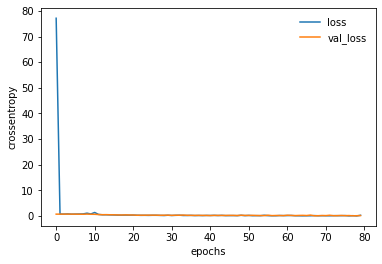

In [11]:
# グラフ表示
plt.plot(log.history['loss'], label='loss')          #学習データ
plt.plot(log.history['val_loss'], label='val_loss')  #検証データ
plt.legend(frameon=False) # 凡例の表示
plt.xlabel("epochs")
plt.ylabel("crossentropy")
plt.show()

In [12]:
# 予測
Y_pred = np.argmax(model.predict(X_test), axis=1)
Y_pred

array([1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1,
       0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0,

In [13]:
# カテゴリー変数の復元
Y_test_ = np.argmax(Y_test, axis=1)
Y_test_

array([1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0,

In [14]:
# モデルの評価
from sklearn.metrics import classification_report

print(classification_report(Y_test_, Y_pred))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95       235
           1       0.93      0.97      0.95       217

    accuracy                           0.95       452
   macro avg       0.95      0.95      0.95       452
weighted avg       0.95      0.95      0.95       452



In [15]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_true=Y_test_, y_pred=Y_pred)
print("予測率:", accuracy*100, "%")

予測率: 94.91150442477876 %
